# PNOF4-VQE

Most common natural orbital functionals (NOFs) can be represented using the energy expression
\begin{equation*}
  E = 2 \sum_p n_p H_{pp} + \sum_{pq} A_{pq} J_{qp} - \sum_{pq} B_{pq} K_{qp} - \sum_{pq} C_{pq} L_{qp}
\end{equation*}
with $p$ and $q$ corresponding to spatial natural orbitals, and $n_p \in [0,1]$ denoting the occupation number of the $p^{th}$-orbital. Complementary, the associated hole is given by $h_p = 1 - n_p$. These NOFs can be classified according to the integrals that appear in their functional expression.

**PNOF4** is a $JKL$-type functional with the following coefficients:

\begin{equation*}
    A_{pq} = \begin{cases}
        2(n_p n_q - \Delta_{pq}), & \text{if $p \neq q$} \\
        n_p, & \text{if $p = q$} \\
  \end{cases} 
\end{equation*}

\begin{equation*}
    B_{pq} = \begin{cases}
        n_p n_q - \Delta_{pq}, & \text{if $p \neq q$} \\
        0, & \text{if $p=q$} \\
  \end{cases} 
\end{equation*}

\begin{equation*}
    C_{pq} = \begin{cases}
        \sqrt{h_p h_q}, & \text{if $p \leq F$, $q \leq F$, $p \neq q$} \\
        \sqrt{\frac{h_p n_q}{S_F} \left(n_p - n_q + \frac{h_p n_q}{S_F} \right)}, & \text{if $p \leq F$, $q > F$} \\
        \sqrt{\frac{n_p h_q}{S_F} \left(n_q - n_p + \frac{n_p h_q}{S_F} \right)}, & \text{if $p > F$, $q \leq F$} \\
        -\sqrt{n_p n_q}, & \text{if $p > F$, $q > F$, $p \neq q$} \\
        0, & \text{if $p = q$} \\
  \end{cases} 
\end{equation*}

with $F = \mathbb{N}/2$ corresponding to the Fermi level and $\mathbb{N}$ indicating the number of electrons. In addition, we also define the following auxiliary matrices:
\begin{equation*}
    \Delta_{pq} = \begin{cases}
        h_p h_q, & \text{if $p \leq F$, $q \leq F$, $p \neq q$} \\
        \left(\frac{1-S_F}{S_F}\right) h_p n_q, & \text{if $p \leq F$, $q > F$}\\
        \left(\frac{1-S_F}{S_F}\right) n_p h_q, & \text{if $p > F$, $q \leq F$}\\
        n_p n_q, & \text{if $p > F$, $q > F$, $p \neq q$} \\
  \end{cases} 
\end{equation*}

and
\begin{equation*}
    S_F = \sum_{p=1}^F h_p = \sum_{p=F+1}^\infty n_p
\end{equation*}

Finally, for real orbitals, as used in this work, $L_{pq} = K_{pq}$.

We start by importing some **libraries**

In [1]:
import pennylane as qml
from pennylane import numpy as pnp

from pennylane import FermiC, FermiA
from pennylane import jordan_wigner

import jax
from jax import numpy as jnp

jax.config.update("jax_enable_x64", True)

For exemplification purposes, we define a **system**, in this case $H_2$ at the bonding distance. We also compute monoelectronic and bielectronic integrals and other useful data.

In [2]:
symbols = ["H", "H"]
geometry = pnp.array([[0.0, 0.0, 0.0], [0.7414, 0.0, 0.0]], requires_grad=False)

mol = qml.qchem.Molecule(symbols, geometry, unit="angstrom")
core, h_MO, I_MO = qml.qchem.electron_integrals(mol)()
E_nuc = core[0]

norb = pnp.shape(h_MO)[0]
qubits = 2 * norb

electrons = mol.n_electrons

# Fermi level
F = int(electrons / 2)

The **ansatz** is built using Hartree-Fock as the reference state and a double excitation gate. Other ansatz can be used for more complex systems.

In [3]:
hf_state = [1] * electrons + [0] * (qubits - electrons)

def ansatz(params):
    qml.BasisState(hf_state, wires=range(4))
    qml.DoubleExcitation(params, wires=[0, 1, 2, 3])

We build the second quantization **operators for the 1RDM** and **map** them to Pauli operators using Jordan-Wigner. Then we create a **circuit to measure the 1RDM**.

Note that we are actually measuring the triangular part of $\Gamma^\alpha$ and ensuring to be in the domain of reals:
\begin{equation*}
\hat{\Gamma}^\alpha_{qp} = \frac{\hat{a}_{2q}^\dagger \hat{a}_{2p} + \hat{a}_{2p}^\dagger \hat{a}_{2q}}{2}   
\end{equation*}

In [4]:
rdm1_ops = []
for p in range(0, norb):
    for q in range(p, norb):
        cpaq = jordan_wigner(0.5 * (FermiC(2 * p) * FermiA(2 * q) + FermiC(2 * q) * FermiA(2 * p))).simplify()
        #### everything is real by construction
        #### cast coefficients to jax reals to avoid warnings with zero values in imaginary parts
        coeffs = jnp.real(jnp.array(cpaq.terms()[0]))
        obs = cpaq.terms()[1]
        cpaq = coeffs[0] * obs[0]
        for coeff, op in zip(coeffs[1:], obs[1:]):
            cpaq += coeff * op
        ####
        rdm1_ops.append(cpaq)

dev = qml.device("lightning.qubit", wires=qubits)

@qml.qnode(dev)
def rdm1_circuit(params):
    ansatz(params)
    return [qml.expval(op) for op in rdm1_ops]

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


The 1RDM is diagonalized to get the **natural orbital representation**

In [5]:
def get_no_on(rdm1):

    rdm1_aa = jnp.zeros((norb, norb))

    i = -1
    for p in range(0, norb):
        for q in range(p, norb):
            i = i + 1
            rdm1_aa = rdm1_aa.at[p, q].set(rdm1[i])
            rdm1_aa = rdm1_aa.at[q, p].set(rdm1[i])

    n, vecs = jnp.linalg.eigh(rdm1_aa)

    n = n[::-1]
    vecs = vecs[:, ::-1]

    return n, vecs

## PNOF4

Here, we implement a function that:
  - Measures (or receives) a 1RDM
  - Diagonalizes the 1RDM to generate occupation numbers and natural orbitals
  - Transforms the integrals and computes $E_\text{NOF}$

In [6]:
def E_PNOF4(params, rdm1=None):

    if rdm1 is None:
        rdm1 = rdm1_circuit(params)
    n, vecs = get_no_on(rdm1)
    h = 1 - n

    h_NO = jnp.einsum("ij,ip,jq->pq", h_MO, vecs, vecs, optimize=True)
    J_NO = jnp.einsum("ijkl,ip,jq,kq,lp->pq", I_MO, vecs, vecs, vecs, vecs, optimize=True)
    K_NO = jnp.einsum("ijkl,ip,jp,kq,lq->pq", I_MO, vecs, vecs, vecs, vecs, optimize=True)

    S_F = jnp.sum(n[F:])

    Delta = jnp.zeros((norb, norb))
    for p in range(norb):
        for q in range(norb):
            val = 0
            if p < F and q < F:
                val = h[q] * h[p]
            if p < F and q >= F:
                val = (1 - S_F) / S_F * n[q] * h[p]
            if p >= F and q < F:
                val = (1 - S_F) / S_F * h[q] * n[p]
            if p >= F and q >= F:
                val = n[q] * n[p]
            Delta = Delta.at[q, p].set(val)

    Pi = jnp.zeros((norb, norb))
    for p in range(norb):
        for q in range(norb):
            val = 0
            if p < F and q < F:
                val = -jnp.sqrt(jnp.abs(h[q] * h[p]))
            if p < F and q >= F:
                val = -jnp.sqrt(jnp.abs((n[q] * h[p] / S_F) * (n[p] - n[q] + n[q] * h[p] / S_F)))
            if p >= F and q < F:
                val = -jnp.sqrt(jnp.abs((h[q] * n[p] / S_F) * (n[q] - n[p] + h[q] * n[p] / S_F)))
            if p >= F and q >= F:
                val = jnp.sqrt(jnp.abs(n[q] * n[p]))
            Pi = Pi.at[q, p].set(val)

    E1 = 0
    for p in range(norb):
        E1 += 2 * n[p] * h_NO[p, p]
    for p in range(norb):
        E1 += n[p] * J_NO[p, p]

    E2 = 0
    for p in range(norb):
        for q in range(norb):
            if p != q:
                E2 += (n[q] * n[p] - Delta[q, p]) * (2 * J_NO[p, q] - K_NO[p, q])
                E2 += Pi[q, p] * (K_NO[p, q])

    return E_nuc + E1 + E2

We assign a **value to the parameter**. For $H_2$, the value corresponding to the *exact* wavefunction is $\theta=0.22501$.

In [7]:
params = 0.22501

Finally, we evaluate the **energy** $E_\text{PNOF4}$

In [8]:
E_PNOF4(params)

Array(-1.13726966, dtype=float64)

The **gradient** of ${d E_\text{PNOF4}}/{d\theta}$ at this value is

## Minimization

In the following we define the VQE and optimize the parameter starting with a guess value using $E_\text{PNOF4}$ as the objective value.

In [9]:
import matplotlib.pyplot as plt
import optax

max_iterations = 1000
conv_tol = 1e-3

In [10]:
def vqe(E_fn, params):
    opt = optax.sgd(learning_rate=0.1)
    opt_state = opt.init(params)

    E_history = [E_fn(params)]
    params_history = [params]

    for it in range(max_iterations):

        gradient = jax.grad(E_fn)(params)

        updates, opt_state = opt.update(gradient, opt_state)
        params = optax.apply_updates(params, updates)

        params_history.append(params)
        E_history.append(E_fn(params))

        g_maxabs = jnp.max(jnp.abs(gradient))

        print(f"Step = {it},  Energy = {E_history[-1]:.8f} Ha,  Gradient = {g_maxabs:.1e}")

        if g_maxabs <= conv_tol:
            break

    return E_history, params_history

In [11]:
E_history, params_history = vqe(E_PNOF4, 0.1)

Step = 0,  Energy = -1.13183965 Ha,  Gradient = 1.0e-01
Step = 1,  Energy = -1.13267971 Ha,  Gradient = 9.4e-02
Step = 2,  Energy = -1.13339017 Ha,  Gradient = 8.6e-02
Step = 3,  Energy = -1.13399091 Ha,  Gradient = 7.9e-02
Step = 4,  Energy = -1.13449882 Ha,  Gradient = 7.3e-02
Step = 5,  Energy = -1.13492818 Ha,  Gradient = 6.7e-02
Step = 6,  Energy = -1.13529111 Ha,  Gradient = 6.1e-02
Step = 7,  Energy = -1.13559786 Ha,  Gradient = 5.7e-02
Step = 8,  Energy = -1.13585711 Ha,  Gradient = 5.2e-02
Step = 9,  Energy = -1.13607620 Ha,  Gradient = 4.8e-02
Step = 10,  Energy = -1.13626135 Ha,  Gradient = 4.4e-02
Step = 11,  Energy = -1.13641780 Ha,  Gradient = 4.0e-02
Step = 12,  Energy = -1.13655000 Ha,  Gradient = 3.7e-02
Step = 13,  Energy = -1.13666171 Ha,  Gradient = 3.4e-02
Step = 14,  Energy = -1.13675609 Ha,  Gradient = 3.1e-02
Step = 15,  Energy = -1.13683584 Ha,  Gradient = 2.9e-02
Step = 16,  Energy = -1.13690322 Ha,  Gradient = 2.6e-02
Step = 17,  Energy = -1.13696015 Ha,  Gra

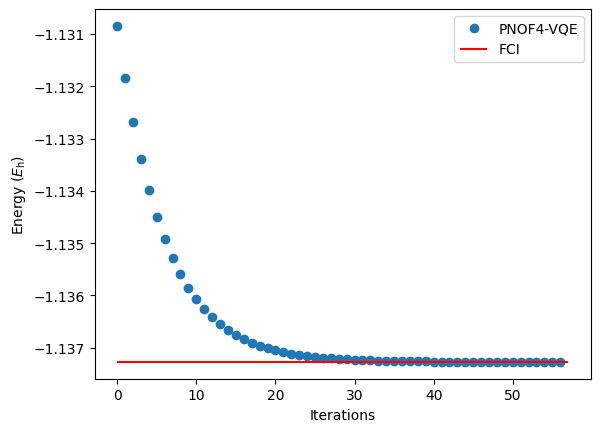

In [12]:
plt.plot(E_history, "o", label="PNOF4-VQE")
plt.hlines(-1.137270174657105, 0, len(E_history), color="red", label = "FCI")
plt.xlabel("Iterations")
plt.ylabel(r"Energy ($E_\text{h}$)")
plt.legend()

In [13]:
jax.grad(E_PNOF4)(params)

Array(-0.00091065, dtype=float64)

## Authors

- Ph.D. Juan Felipe Huan Lew-Yee (felipe.lew.yee@dipc.org)
  - Donostia International Physics Center (DIPC)
- Prof. Mario Piris (mario.piris@ehu.es)
  - Donostia International Physics Center (DIPC)
  - Euskal Herriko Unibertsitatea (UPV/EHU)
  - Basque Foundation for Science (Ikerbasque)

## Acknowldgments

- J. F. H. Lew-Yee acknowledges the **Donostia International Physics Center (DIPC)** and the **Ministerio de Ciencia, Innovación y Universidades (MCIN) program Severo Ochoa** and **Agencia Estatal de Investigación (AEI)** under reference AEI/CEX2018-000867-S for post-doctoral funding (Ref.: 2023/74.)

- M. Piris acknowledges **MCIN** and **AEI** funding from MCIN/AEI/10.13039/501100011033 (Ref.: PID2021-126714 NB-I00) and the **Eusko Jaurlaritza** (Ref.: IT1584-22).

- The authors acknowledge the technical and human support provided by the **DIPC Supercomputing Center**.

- This work has been possible thanks to the quantum resources and ecosystem provided through the **IBM-BasQ** alliance for the development of quantum technologies.

## GitHub:

https://github.com/felipelewyee/NOF-VQE